# Classifying customer complaints with Watson NLP

This notebook demonstrates how to train different text classifiers using Watson NLP. The classifiers predict the product group from the text of a customer complaint. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), a U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains the consumer’s narrative description of their experience if the consumer opted to share this information publicly and after the Bureau has removed all personal information. In this notebook, you will focus on complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a custom SVM model** using `watson_nlp.blocks.classification.SVM`. SVM stands for Support Vector Machines. It's an established classification method. We will run it based on USE (Universal Sentence Encoder) embeddings of the input text.
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.Ensemble`. The Ensemble model combines three classification models: CNN, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1.	[Before you start](#beforeYouStart)
2.	[Load the complaint data](#loadData)
3.	[Prepare training and test data](#prepareData)
4.	[Train a SVM classification model with Watson NLP](#svm)
5.  [Train an ensemble classification model with Watson NLP](#ensemble)
6.  [Store and load classification models](#storeLoad)
7.  [Classify test data and compare model quality](#scoring)
8.  [Summary](#summary)


<a id="beforeYouStart"></a>
## Before you start

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.



Begin by importing and initializing some helper libs that are used throughout the notebook.

In [1]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

import json
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
import watson_nlp

from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.workflows.classification import Ensemble

<a id="loadData"></a>
## Load the complaint data

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. The data contains one month of data and only those complaints that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data looks like this:

In [3]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In your analysis you will focus on the *Product* column, which contains the product group, and the column with the complaint text *Consumer complaint narrative*.

In [4]:
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

complaint_df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/24/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,Ive failed a dispute in regards to the incorrect items on my credit report it has been well over 30 days and I havent received any investigation results.,None,"EQUIFAX, INC.",PA,19143,None,Consent provided,Web,03/24/21,Closed with explanation,Yes,NaN,4239946
1,03/01/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"On the XX/XX/XXXX, I sent in letters regarding inaccurate reporting of false items on my credit report. I have not received their method of verification nor the results of their investigation. I feel like I'm being ignored of my claims and disputes. These are deceptive practices of the bureaus.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33029,None,Consent provided,Web,03/01/21,Closed with explanation,Yes,NaN,4173173


Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [5]:
product_counts = complaint_df['Product'].value_counts()
product_counts

Credit reporting, credit repair services, or other personal consumer reports    8889
Debt collection                                                                 3338
Credit card or prepaid card                                                     1555
Mortgage                                                                        1548
Checking or savings account                                                     1122
Money transfer, virtual currency, or money service                               914
Vehicle loan or lease                                                            373
Payday loan, title loan, or personal loan                                        193
Student loan                                                                     193
Name: Product, dtype: int64

<a id="prepareData"></a>
## Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [6]:
# number of complaints for the each product group
sample_size = 300

train_test_df = complaint_df.query("Product != 'Student loan' and Product != 'Payday loan, title loan, or personal loan'")

# sample the data to have the same number of complaints for each product group
train_test_df = train_test_df.groupby('Product').sample(n=sample_size, random_state=5).reset_index(drop=True)

In the next step, you will split the data into training and test data (ratio:80/20).

In [7]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 1680
Samples by product group:
Checking or savings account                                                     240
Credit card or prepaid card                                                     240
Credit reporting, credit repair services, or other personal consumer reports    240
Debt collection                                                                 240
Money transfer, virtual currency, or money service                              240
Mortgage                                                                        240
Vehicle loan or lease                                                           240
Name: Product, dtype: int64

Test data:
Number of test samples: 420
Samples by product group:
Checking or savings account                                                     60
Credit card or prepaid card                                                     60
Credit reporting, credit repair services, or other personal consumer reports  

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

In the sample, you will create the data in *JSON* format. The training and test data is written to files.

In [8]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[[text_col, 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={text_col: "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,"I have been unable to close my SoFi XXXX, Active Investing & Crypto Investing accounts because my Crypto Currency account has a {$.00} balance which is below the minimumSoFirequires initiate a trade. I entered an order to "" Sell All '' my Crypto Currency balance on XX/XX/XXXX butSoFicompleted the transaction leaving my account with a {$.00} balance. I have requested thatSoFiclose my account on...",[Checking or savings account]
1,"On XX/XX/XXXX, my Bank of America account was charged by XXXX for a meal kit delivery with an expected delivery date of XX/XX/XXXX. The morning of XX/XX/XXXX, this package showed no indication of even having left the warehouse, much less being in transit for delivery, and following a pattern of this behavior by the merchant, I contacted XXXX to inquire as to my order status, which they were un...",[Checking or savings account]


<a id="svm"></a>
## Train a SVM classification model with Watson NLP

SVM is an establishd classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [9]:
# Syntax Model
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
# USE Embedding Model
use_model = watson_nlp.load('embedding_use_en_stock')

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [10]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

Train the classifier. **Note:** This cell will run for several minutes.

In [11]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## Train an ensemble classification model with Watson NLP

The ensemble model combines three classification models: 

- CNN 
- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 

It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the GloVe and USE embeddings. They are passed with the file containing the training data.

Train the ensemble classifier. **Note:**  This cell will run for several minutes. To restrict the time, we limited the epochs to train the CNN classifier to 5. This is an _optional_ attribute - if not specified, the default will be 30 epochs.

To speed up the training time for your own data, consider using a custom environment with GPU, based on _Runtime 22.2_ or _Runtime 22.1_. It also contains the NLP capabilities, but uses GPUs for training, which will be faster.

In [12]:
glove_model = watson_nlp.load('embedding_glove_en_stock')

In [13]:
ensemble_model = Ensemble.train(train_file, syntax_model, glove_model, use_model, cnn_epochs=5)

# Stopword removal can also be applied as an optional preprocessing step for SVM TFIDF classifier. This should be experimented with for each use case.
# stopwords = watson_nlp.load('text_stopwords_classification_ensemble_en_stock')
# ensemble_model = Ensemble.train(train_file, syntax_model, glove_model, use_model, stopwords=stopwords, cnn_epochs=5) 

Epoch 1/5
27/27 - 83s - loss: 3.7487 - categorical_accuracy: 0.1655 - 83s/epoch - 3s/step
Epoch 2/5
27/27 - 80s - loss: 1.8979 - categorical_accuracy: 0.3042 - 80s/epoch - 3s/step
Epoch 3/5
27/27 - 80s - loss: 1.0148 - categorical_accuracy: 0.4768 - 80s/epoch - 3s/step
Epoch 4/5
27/27 - 78s - loss: 0.6189 - categorical_accuracy: 0.6250 - 78s/epoch - 3s/step
Epoch 5/5
27/27 - 78s - loss: 0.4433 - categorical_accuracy: 0.6804 - 78s/epoch - 3s/step


In [14]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

In [15]:
wslib.save_data('svm_model', data=svm_model.as_bytes(), overwrite=True)

{'name': 'svm_model',
 'asset_type': 'data_asset',
 'asset_id': 'f0a2b5fd-1c6d-4fbb-a7fb-8a9efb26b736',
 'attachment_id': 'fd76173a-f81f-4eef-afdd-0e4d9e4d775e',
 'filepath': 'svm_model.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [16]:
wslib.save_data('ensemble_model', data=ensemble_model.as_bytes(), overwrite=True)

{'name': 'ensemble_model',
 'asset_type': 'data_asset',
 'asset_id': 'c33cd7c2-e075-4e44-a68e-5ef8ead01627',
 'attachment_id': 'c66f7eb0-02dd-45ad-9e23-97f1ba5a9f08',
 'filepath': 'ensemble_model.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [17]:
svm_model = watson_nlp.load(wslib.load_data('svm_model'))

In [18]:
ensemble_model = watson_nlp.load(wslib.load_data('ensemble_model'))

<a id="scoring"></a>
## Classify test data and compare model quality

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the CNN model requires you to run the syntax model on the input texts first.

Create a helper method to run both models on a single complaint and return the predicted product groups of both models.

In [19]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)

Run the models on the complete test data.

In [20]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
   
result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

,Consumer complaint narrative,Product,Predicted SVM,Predicted Ensemble
0,My account was closed on XX/XX/21 for what they said was a suspicious XXXX payment credited to my account. I have been on the phone everyday with them since for hours trying to get this all sorted out and chatting in. They say i wont get my money until may and they wont give me any funds. This is absolutely ridiculous. How am i supposed to live without my money? This is criminal. I need my fun...,Checking or savings account,"Money transfer, virtual currency, or money service","Money transfer, virtual currency, or money service"
1,XXXX XXXX XXXX sent me a debit card that was fraudulent opened with all my information ... .there were no charges and they closed account on XXXX ... .account was opened XX/XX/XXXX using my name birthdate ss # and address and cell phone .... \nChase bank also same thing someone attempted to open debit card and account with my information on XX/XX/XXXX ... account has been closed.,Checking or savings account,Checking or savings account,Checking or savings account
2,"On XX/XX/2021, morning of I checked my account online my phone app. Shocked as there were 206 transactions unauthorized by XXXX TEST, INTERNET, CA, USA ). AND ( XXXX * Test, XXXX, CA, USA. ) XXXX #, CA, USA. AS WELL AS ( XXXX Test, XXXX XXXX, CA, USA These charges were unauthorized and had taken {$240.00} out of my Account in which was part of the second stimulus $ received. They took every bi...",Checking or savings account,Checking or savings account,Credit card or prepaid card
3,On XX/XX/2021 at approximately XXXX. My account was breached and funds were took in out for a total of XXXX. Phone number including pin and password were changed in my account. They suspended my account because of a money transfer now I have no money and chime isnt giving me answers. They unauthorized merchant was ( XXXX ) for a total of 4 times adding up to the amount listed above. The bank i...,Checking or savings account,Checking or savings account,Checking or savings account
4,"Friday XX/XX/21 Chase sent 2 unauthorized wires of {$5500.00} each + {$25.00} fee per transaction XXXX they did reverse the fee ). They confirmed on their recorded lines that this was done in error ; this was a "" glitch '' and should be corrected by midnight. They assured us they would contact their wiring department to return funds in case they didn't reappear in our account the next morning,...",Checking or savings account,Checking or savings account,Checking or savings account


### Out-of-the-box model evaluation using Watson NLP

Watson NLP offers a method to calculate different quality metrics for a given model. Use the test data to evaluate the quality of your models.

In [21]:
# run the models on the test data - this time in batch mode
preprocess_func = lambda raw_doc: use_model.run_batch(syntax_model.run_batch(raw_doc))
svm_model.evaluate_quality(test_file, preprocess_func=preprocess_func)

{'per_class_confusion_matrix': {'Checking or savings account': {'true_positive': 11,
   'false_positive': 120,
   'false_negative': 49,
   'precision': 0.08396946564885496,
   'recall': 0.18333333333333332,
   'f1': 0.11518324607329843},
  'Credit card or prepaid card': {'true_positive': 5,
   'false_positive': 53,
   'false_negative': 55,
   'precision': 0.08620689655172414,
   'recall': 0.08333333333333333,
   'f1': 0.08474576271186442},
  'Debt collection': {'true_positive': 15,
   'false_positive': 87,
   'false_negative': 45,
   'precision': 0.14705882352941177,
   'recall': 0.25,
   'f1': 0.18518518518518517},
  'Credit reporting, credit repair services, or other personal consumer reports': {'true_positive': 3,
   'false_positive': 54,
   'false_negative': 57,
   'precision': 0.05263157894736842,
   'recall': 0.05,
   'f1': 0.05128205128205128},
  'Money transfer, virtual currency, or money service': {'true_positive': 2,
   'false_positive': 27,
   'false_negative': 58,
   'preci

You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes. 

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

### Creating and plotting a confusion matrix

Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.

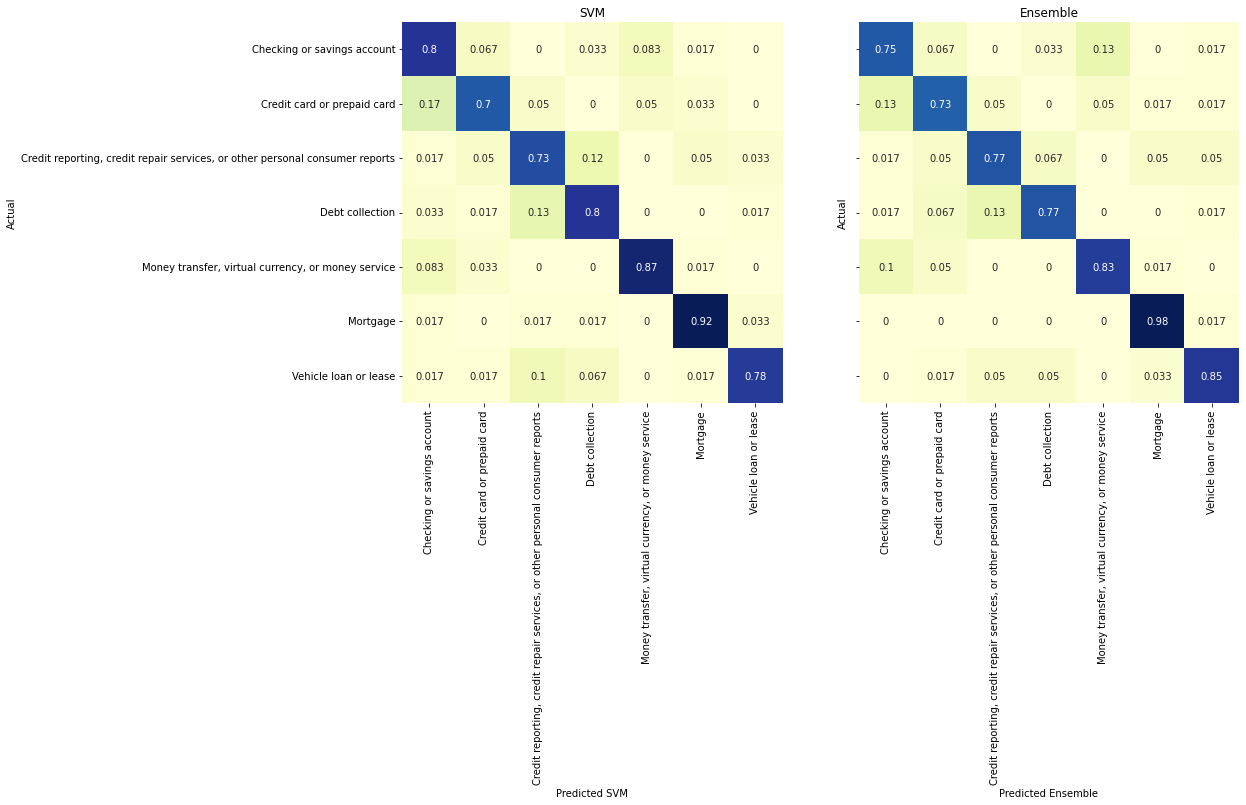

In [22]:
SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

In the confusion matrix for the SVM model you can now see that complaints for `Credit reporting, credit repair services, or other personal consumer reports` are often misclassified as `Debt collection` - and vice versa. Other common misclassifications can be gathered from the table.

Overall, the ensemble model performs better than the SVM model. However, the SVM model had a significantly shorter training time. 

In subsequent steps, consider increasing the size of the training data, tuning the CNN training parameters or adjusting the  weights of the ensemble model to gain better results.

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.